In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
from scipy.constants import m_e,m_p,m_n

from utils import timeit, PBC_wrapping
from forcefield import LennardJonesPotential, construct_param_matrix
from simpleMD import compute_Hem
from simpleMD import SimpleDynamicModelEM as oldSimpleDynamicModelEM
import constants

The Jacobi of the dipole function has the form:
\begin{align*}
    \begin{bmatrix}
    \partial \mu_x / \partial r_x & \partial \mu_y / \partial r_x & \partial \mu_z / \partial r_x 
    \\
    \partial \mu_x / \partial r_y & \partial \mu_y / \partial r_y & \partial \mu_z / \partial r_y 
    \\
    \partial \mu_x / \partial r_z & \partial \mu_y / \partial r_z & \partial \mu_z / \partial r_z
    \end{bmatrix}
\end{align*}

In [76]:
sm_Rax = sm.symbols("Rax")
sm_Ray = sm.symbols("Ray")
sm_Raz = sm.symbols("Raz")
sm_Ra = [sm_Rax, sm_Ray, sm_Raz]

sm_Rbx = sm.symbols("Rbx")
sm_Rby = sm.symbols("Rby")
sm_Rbz = sm.symbols("Rbz")
sm_Rb = [sm_Rbx, sm_Rby, sm_Rbz]

sm_mu0 = sm.symbols("mu0")
sm_a = sm.symbols("a")
sm_d0 = sm.symbols("d0")
sm_d1 = sm.symbols("d1")
sm_d2 = sm.symbols("d2")
sm_d7 = sm.symbols("d7")

class SymbolicBaseDipoleFunction:
    def __init__(self):
        
        self.dipole_function = [
            sm.lambdify(
            [sm_Rax, sm_Ray, sm_Raz, sm_Rbx, sm_Rby, sm_Rbz, 
             ] + self.parameters_sm, 
                dipole_exp
        ) for dipole_exp in self.dipole_exp]
        
        self.generate_Jacobi()
        #self.generate_Hessian()

    def generate_Jacobi(self):
        self.Ja_exp = [[],[],[]]
        self.Ja_func = [[],[],[]]

        self.Jb_exp = [[],[],[]]
        self.Jb_func = [[],[],[]]

        for i,Ra in enumerate(sm_Ra):
            for j,dipole_f in enumerate(self.dipole_exp):
                d_mu = sm.diff(dipole_f, Ra)
                self.Ja_exp[i].append(d_mu)
                self.Ja_func[i].append(sm.lambdify(
                    [sm_Rax, sm_Ray, sm_Raz, sm_Rbx, sm_Rby, sm_Rbz, 
                    ]+ self.parameters_sm, d_mu
                ))

                d_mu = sm.diff(dipole_f, sm_Rb[i])
                self.Jb_exp[i].append(d_mu)
                self.Jb_func[i].append(sm.lambdify(
                    [sm_Rax, sm_Ray, sm_Raz, sm_Rbx, sm_Rby, sm_Rbz, 
                    ]+ self.parameters_sm, d_mu
                ))

    def __call__(self, r):
        """
        Note: 
        ra should be the positive particle and 
        rb should be the negative particle
        """
        ra = list(r[0])
        rb = list(r[1])

        args = ra + rb + self.parameters

        result = [dipole_f(*args) for dipole_f in self.dipole_function]
        
        return result

    def gradient(self,r,sign):
        ra = list(r[0])
        rb = list(r[1])
        args = ra + rb + self.parameters

        all_result = []
        for sign_ in sign:
            result = np.zeros((3,3))
            
            if sign_ == "+": 
                J_func = self.Ja_func
            elif sign_ == "-": 
                J_func = self.Jb_func
                
            for i, dmu_dRa in enumerate(J_func):
                for j, dmu_i_dRa in enumerate(dmu_dRa):
                    result[i,j] = dmu_i_dRa(*args)

            all_result.append(result)

        return all_result
    
class SymbolicGriegorievDipoleFunction(SymbolicBaseDipoleFunction):
    def __init__(self, mu0, a, d0, d7):

        sm_d = ((sm_Rax - sm_Rbx)**2 + (sm_Ray - sm_Rby)**2 \
             + (sm_Raz - sm_Rbz)**2)**(1/2)
        
        self.parameters = [mu0, a, d0, d7]
        self.parameters_sm = [sm_mu0, sm_a, sm_d0, sm_d7]
        self.dipole_exp = [
            ((sm_Ra[i] - sm_Rb[i])/sm_d) *\
            (sm_mu0 * sm.exp(-sm_a*(sm_d-sm_d0)))# - sm_d7/(sm_d**7))
            for i in range(3)
        ]
        
        super().__init__()

class SimpleGriegorievDipoleFunction:
    def __init__(self, mu0, a, d0, L=None):
        self.mu0 = mu0
        self.a = a
        self.d0 = d0
        self.L = L

    def __call__(self,r_plus,r_minus,change_of_basis_matrix=None):
        rij = PBC_wrapping(r_plus - r_minus, self.L)
        if change_of_basis_matrix is not None:
            rij = change_of_basis_matrix @ rij
        d = np.sqrt(np.sum(rij**2))

        return self.mu0 * np.exp(-self.a * (d - self.d0)) * rij / d

    def gradient(self,r_plus,r_minus,change_of_basis_matrix=None):
        """
        The order of the position argument does not matter
        To get the gradient w.r.t. the negative particle/atom, 
        put a minus sign on the output gradient.
        """
        rij = PBC_wrapping(r_plus - r_minus, self.L)
        if change_of_basis_matrix is not None:
            rij = change_of_basis_matrix @ rij
        d2 = np.sum(rij**2)
        d = np.sqrt(d2)

        rij_outer = np.outer(rij, rij)
        mu_exp = self.mu0 * np.exp(-self.a * (d - self.d0))
        
        grad_mu =  - self.a * rij_outer * mu_exp / d2 
        grad_mu += - mu_exp * rij_outer / (d2 * d)
        grad_mu += mu_exp * np.eye(3) / d

        return grad_mu#[grad_mu, -grad_mu]

    def total_dipole(self, r, plus_idx_list, minus_idx_list):
        dipole_vec = np.zeros(3)
        for pi in plus_idx_list:
            for mj in minus_idx_list:
                dipole_vec += self.__call__(r[pi], r[mj])
        return np.sqrt(dipole_vec @ dipole_vec)
        

dipole_function1 = SymbolicGriegorievDipoleFunction(mu0=0.0284, a=1.22522, d0=7.10, d7=0)#14200)
dipole_function2 = SimpleGriegorievDipoleFunction(mu0=0.0284, a=1.22522, d0=7.10)

r_xe = np.array([0,0,0])
r_ar = np.array([2,1,3])

print(dipole_function1([r_xe,r_ar]))
print(dipole_function1.gradient([r_xe,r_ar],["+","-"]))

print(dipole_function2.gradient(r_ar,r_xe))

[-0.9295645005540366, -0.4647822502770183, -1.3943467508310547]
[array([[-0.27679157, -0.37078691, -1.11236073],
       [-0.37078691,  0.2793888 , -0.55618036],
       [-1.11236073, -0.55618036, -1.20375884]]), array([[ 0.27679157,  0.37078691,  1.11236073],
       [ 0.37078691, -0.2793888 ,  0.55618036],
       [ 1.11236073,  0.55618036,  1.20375884]])]
[[-0.27679157 -0.37078691 -1.11236073]
 [-0.37078691  0.2793888  -0.55618036]
 [-1.11236073 -0.55618036 -1.20375884]]


\begin{align*}
\dot{\textbf{C}}_k + i\omega \textbf{C}_k &= \frac{ie^{-i\textbf{k}\cdot \textbf{r}_\mu} }{\omega} \left(I - \frac{\textbf{k} \textbf{k}^T}{|\textbf{k}|} \right) \left( \frac{\partial \mu}{\partial \textbf{r}_{Ar} } \dot{\textbf{r}}_{Ar} + \frac{\partial \mu}{\partial \textbf{r}_{Xe} } \dot{\textbf{r}}_{Xe} \right)
\\
\omega &= ck
\end{align*}

\begin{align*}
    m_{Ar} \ddot{\textbf{r}}_{Ar}^{[\textbf{k}]} &= \sum_{i\neq \textbf{k}} \sum_{j \neq \textbf{k}} \dot{\textbf{r}}_{Ar}^{[i]} \frac{\partial \textbf{A}^{[j]} (\textbf{r}_\mu) }{\partial \textbf{r}^{[\textbf{k}]}_{Ar}}  \frac{\partial \mu^{[j]}}{\partial \textbf{r}_{Ar}^{[i]}} 
    - \sum_{j\neq\textbf{k}} \frac{\partial \textbf{A}^{[j]} (\textbf{r}_\mu) }{\partial t}  \frac{\partial \mu^{[j]}}{\partial \textbf{r}_{Ar}^{[\textbf{k}]}} 
    \\
    m_{Ar} \ddot{\textbf{r}}_{Ar}^{[\textbf{k}1]} 
    &= - \sum_j \frac{\partial \textbf{A}^{[j]} (\textbf{r}_\mu) }{\partial t}  \frac{\partial \mu^{[j]}}{\partial \textbf{r}_{Ar}^{[\textbf{k}1]}} 
    - \sum_{j\neq \textbf{k}} \dot{\textbf{r}}_{Ar}^{[\textbf{k}]} \frac{\partial \textbf{A}^{[j]} (\textbf{r}_\mu) }{\partial \textbf{r}_{Ar}^{[\textbf{k}]}} \frac{\partial \mu^{[j]}}{\partial \textbf{r}_{Ar}^{[\textbf{k}1]}}
\end{align*}

Note that, for simplicity, we currently choose:
\begin{align*}
    \mathbf{x} &= \mathbf{k}
    \\
    \mathbf{y} &= \mathbf{k1}
    \\
    \mathbf{z} &= \mathbf{k2}
\end{align*}

In [3]:
def gram_schmidt(vec1, vec2, vec3 ):
    orthonormal = [vec1 / np.sqrt(vec1 @ vec1)]

    for vec_i in [vec2,vec3]:
        
        for orthonormal_vec in orthonormal:
            vec_i -= orthonormal_vec.T @ vec_i * orthonormal_vec
            
        orthonormal.append(vec_i / np.sqrt(vec_i @ vec_i))

    return orthonormal

def epsilon_generator(k_vec):
    unit_vec_list = np.eye(3)
    foo = np.argsort(abs(k_vec))
    
    orthonormal = gram_schmidt(
        k_vec,
        unit_vec_list[foo[0]],
        unit_vec_list[foo[1]]
    )

    return np.array(orthonormal[1:])

k_vec = np.array([1e-2,1e-3,1e1],dtype=np.float64)
epsilon = np.array(epsilon_generator(k_vec))

print(epsilon)
print(k_vec @ epsilon.T)
print(epsilon @ epsilon.T)

[[-9.99998995e-08  9.99999995e-01 -9.99998995e-05]
 [ 9.99999500e-01 -1.32348964e-23 -9.99999500e-04]]
[-2.16840434e-19  0.00000000e+00]
[[ 1.00000000e+00 -1.95178198e-23]
 [-1.95178198e-23  1.00000000e+00]]


In [4]:
constants.c

137.0

In [86]:
from simpleMD import compute_Hem
from utils import PBC_wrapping

class SimpleDynamicModelEM:
    def __init__(
            self, k_vec, epsilon, M, dipole_function, argon_idx, xenon_idx,
            potential=None, L=None):

        """
        Class of simple model for molecular dyanamic simulation
        for charged particle in EM field
        Args: 
        + q (list/ np.array of int): charge value of particles
        + k_vec (np.array): list of array of k vectors for the EM field
            have shape of n_mode x 3 with n_mode is int >= 1
        + epsilon (np.array): list or array of pairs of polarization vector modes
            for the EM field. Have the shape of n_mode x 2 x 3
        + k_const (float): constant for the Harmonic Oscillator
        + potential (None, MorsePotential, will add more class later):
            'engine' for potential or force computing
        """

        #assert len(q) == len(v) and len(v) == len(r)
        #assert C.shape[0] == k_vec.shape[0]

        if len(k_vec.shape) < 2:
            k_vec = k_vec.reshape(1,3)
        else: 
            assert k_vec.shape[1] == 3
        self.k_vec = k_vec

        if len(epsilon.shape) < 3:
            epsilon = epsilon.reshape(1,2,3)
        else:
            assert epsilon.shape[1] == 2 and epsilon.shape[2] == 3
        self.epsilon = epsilon

        self.potential = potential
      
        self.k = []; self.omega = []
        for vec in k_vec:
            k = np.sqrt(vec @ vec.T)
            self.k.append(k)
            self.omega.append( constants.c * k)
            
        self.M = np.tile(M[:,np.newaxis], (1,3) )
        self.dipole_func = dipole_function

        # list of unit vector along the wavevector k, hence epsilon_k
        self.epsilon_k = [self.k_vec[i] / self.k[i] for i in range(len(self.k))]

        self.change_of_basis_mat = [
            np.vstack([self.epsilon_k[i], self.epsilon[i]]) for i in range(len(self.k_vec))
        ]

        self.L = L
        self.potential.L = L
        self.dipole_func.L = L

        self.argon_idx = argon_idx
        self.xenon_idx = xenon_idx

    def dot_C(self, r, v, C):
        """
        Computing partial derivative of C w.r.t. time, a.k.a. C_dot
        Args:
        + r (np.array): list/array of postition of charged particles. Shape: n_particles x 3
        + v (np.array): list/array of velocities of charged particles. Shape: n_particles x 3
        + C (np.array): list/array of pair of modes
        """

        C_dot = []

        for j, k_vec in enumerate(self.k_vec):

            jk = 0
            
            for xe_j in self.xenon_idx:
                for ar_i in self.argon_idx:
                    mu_grad = self.dipole_func.gradient(r[xe_j], r[ar_i])
                    
                    jk += np.exp(-1j * k_vec @ r[ar_i]) * -mu_grad.T @ v[ar_i] 
                    jk += np.exp(-1j * k_vec @ r[xe_j]) *  mu_grad.T @ v[xe_j] 

            jk_transv = (np.eye(3) - np.outer(k_vec, k_vec) / (self.k[j]**2)) @ jk

            proj_jk_transv = np.array([
                jk_transv @ e for e in self.epsilon[j] 
                ])
            
            C_dot.append( -1j * self.omega[j] * C[j] + \
                (2 * np.pi * 1j / self.k[j]) * proj_jk_transv)

        C_dot = np.array(C_dot)
        return C_dot

    def compute_force(self, r, v, C):
        
        F = self.compute_transv_force(r=r, v=v, C=C)

        if self.potential is not None:
            F += self.potential.get_force(r)

        return F
    
    def compute_Hmat_transv(self,r,v):
        K = 0
        for i, vi in enumerate(v):
            K += 0.5 * (self.M[i] * vi) @ vi.T
        return K

    def compute_H(self, r, v, C):
        H_mat = self.compute_Hmat_transv(r=r, v=v)
        H_em = compute_Hem(self.k_vec, C)

        H_mat += self.potential.get_potential(r)

        return H_em, H_mat

    def pde_step(self, r, v, C):
        a = self.compute_force(r,v,C) / self.M
        C = self.dot_C(r,v,C)
        r = v
        return r, a, C

    def rk4_step(self, r, v, C, h):
        k1r, k1v, k1c = self.pde_step(
            r=r ,v=v, C=C)
        k2r, k2v, k2c = self.pde_step(
            r=r+k1r*h/2, v=v+k1v*h/2, C=C+k1c*h/2)
        k3r, k3v, k3c = self.pde_step(
            r=r+k2r*h/2, v=v+k2v*h/2, C=C+k2c*h/2)
        k4r, k4v, k4c = self.pde_step(
            r=r+k3r*h, v=v+k3v*h, C=C+k3c*h)

        r = r + (h/6) * (k1r + 2*k2r + 2*k3r + k4r)
        r = PBC_wrapping(r, self.L)
        v = v + (h/6) * (k1v + 2*k2v + 2*k3v + k4v)
        C = C + (h/6) * (k1c + 2*k2c + 2*k3c + k4c)

        return r, v, C

    def compute_transv_force(self, r, v, C):
        C_dot = self.dot_C(r,v,C)
        
        ma_list = []

        for j, rj in enumerate(r):
            _ma_ = np.array([0+0j,0+0j,0+0j])
            # sum over all wavevector k
            for l, k_vec in enumerate(self.k_vec):

                if j in self.argon_idx:
                    mu_grad = 0
                    for xe_i in self.xenon_idx:
                        mu_grad += -self.dipole_func.gradient(
                            r[xe_i],rj,self.change_of_basis_mat[l])
                        
                elif j in self.xenon_idx:
                    mu_grad = 0
                    for ar_i in self.argon_idx:
                        mu_grad += self.dipole_func.gradient(
                            rj,r[ar_i],self.change_of_basis_mat[l])
                else:
                    raise Exception
                
                # k part
                vk  =  self.epsilon_k[l] @ v[j].T # projection of v on k_vec
                vk1 = self.epsilon[l][0] @ v[j].T # projection of v on epsilon_k1
                vk2 = self.epsilon[l][1] @ v[j].T # projection of v on epsilon_k2
                vkj = [vk1, vk2]

                # C[0] = 0;  C[1] = C_{k1}; C[2] = C_{k2}
                k = self.k[l]
                
                _ma_k = 0
                for m in [1,2]:
                    for n in [1,2]:
                    
                        _ma_k +=   vkj[n-1] * (1j * k * C[l][m-1] * np.exp(1j * k_vec @ rj) \
                                + np.conjugate(1j * k * C[l][m-1] * np.exp(1j * k_vec @ rj)) ) \
                                * mu_grad[n][m]
                        
                    foo =           (-C_dot[l][m-1] * np.exp(1j * k_vec @ rj) +  \
                        np.conjugate(-C_dot[l][m-1] * np.exp(1j * k_vec @ rj)) ) \
                        * mu_grad[0][m]
                    
                    _ma_k += foo
                    
                _ma_ += _ma_k * self.epsilon_k[l]

                # epsilon part
                for i in [1,2]:
                    _ma_ki = 0
                    for m in [1,2]:
                        _ma_ki +=       (-C_dot[l][m-1] * np.exp(1j * k_vec @ rj) + \
                            np.conjugate(-C_dot[l][m-1] * np.exp(1j * k_vec @ rj)) )\
                            * mu_grad[i][m]

                        _ma_ki +=   -vk * (1j * k * C[l][m-1] * np.exp(1j * k_vec @ rj) \
                            + np.conjugate(1j * k * C[l][m-1] * np.exp(1j * k_vec @ rj)) )\
                            * mu_grad[i][m]
                       
                    _ma_ += _ma_ki * self.epsilon[l][i-1]

            _ma_ /= constants.c

            ma_list.append(np.real(_ma_))

        return np.array(ma_list)

n_pair = 2
r_ar = np.array([
    [ 5, 0, 0],
    [ 0, 5, 0]
]) # Argon should be negative
#r_ar = np.random.uniform(-L/2,L/2, size = (n_pair,3))
r_xe = np.array([
    [-5, 0, 0],
    [ 0,-5, 0]
]) # Xenon should be positive
#r_xe = np.random.uniform(-L/2,L/2, size = (n_pair,3))

v_ar = np.array([
    [-1, 0, 0],
    [0, -1, 0]
]) * 1e1
#v_ar = np.random.uniform(-1e2,1e2, size = (n_pair,3))
v_xe = np.array([
    [1, 0, 0],
    [0, 1, 0]
]) * 1e1
#v_xe = np.random.uniform(-1e2,1e2, size = (n_pair,3))

Z_Ar = 18
m_Ar = Z_Ar * (m_p / m_e) + Z_Ar + (40 - Z_Ar) * (m_n / m_e) 
Z_Xe = 54
m_Xe = Z_Xe * (m_p / m_e) + Z_Xe + (131 - Z_Xe) * (m_n / m_e)

L = 40

"""
k_vec = np.random.randint(-10,10,size = (8,3)) * (2 * np.pi/L)
"""
k_vec = np.array([
    #np.array([1e0, 0  , 0  ],dtype = np.float64)/constants.c,
    #np.array([  0, 1e0, 0  ],dtype = np.float64)/constants.c,
    #np.array([  0, 0  , 1e0],dtype = np.float64)/constants.c,
    #np.array([1e0, 1e0, 0  ],dtype = np.float64)/constants.c,
    #np.array([  0, 1e0, 1e0],dtype = np.float64)* (2 * np.pi/L),
    #np.array([1e0, 0  , 1e0],dtype = np.float64)/constants.c,
    np.array([1e0, 1e0, 1e0],dtype = np.float64)* (2 * np.pi/L),
])

"""
k_vec = np.array([
    #np.array([  0, 1e-1, 0  ],dtype = np.float64)/constants.c,
    #np.array([  0, 1e0, 0  ],dtype = np.float64) * (2 * np.pi/L),
    #np.array([  0, 5e0, 0  ],dtype = np.float64) * (2 * np.pi/L),
    #np.array([  0, 1e1, 0  ],dtype = np.float64)/constants.c,
    #np.array([  0, 2.5e1, 0  ],dtype = np.float64)/constants.c,
    #np.array([  0, 5e1, 0  ],dtype = np.float64)/constants.c,
    #np.array([  0, 7.5e1, 0  ],dtype = np.float64)/constants.c,
    #np.array([  0, 1e2, 0  ],dtype = np.float64)/constants.c,
])
"""

epsilon_vec = np.stack([
    epsilon_generator(k) for k in k_vec
])

n_modes = len(k_vec)
#C = (np.random.rand(n_modes,2) + 1j * np.random.rand(n_modes,2)) * 1e3
C = (np.ones((n_modes,2)) + 1j * np.ones((n_modes,2))) * 1e1

assert n_modes == C.shape[0] and n_modes == len(k_vec) and n_modes == len(epsilon_vec)


dipole_func = SimpleGriegorievDipoleFunction(
    mu0=0.0124 , a=1.5121, d0=7.10, L = L
)

pure_epsilon = np.array([
    1.904, #xenon
    0.996, #argon
]) * 1.59360e-3
mixed_epsilon = 1.377 * 1.59360e-3

pure_sigma = np.array([
    4.06, #xenon
    3.41, #argon
]) * (1e-10 / 5.29177e-11)
mixed_sigma = 3.735 * (1e-10 / 5.29177e-11)

epsilon = construct_param_matrix(n_pair*2,n_pair,pure_epsilon,mixed_epsilon)
sigma = construct_param_matrix(n_pair*2,n_pair,pure_sigma,mixed_sigma)

lennardj = LennardJonesPotential(
    n_points = n_pair*2,
    epsilon = epsilon,
    sigma = sigma,
    L = L)

trajectory = {
    "initial r_Ar": r_ar, "initial r_Xe": r_xe,
    "initial v_Ar": v_ar, "initial v_Xe": v_xe,
    "k vector":k_vec, "C":C, "h":0,
    "H_rad" : [], "H_mat" : [], "total_H" : [],
    "dipole" : [],
    "steps" : [],
    "r" : []
}

In [87]:
class PotentialVectorField:
    def __init__(self, k, epsilon, C):
        self.k = k
        self.epsilon = epsilon
        self.C = C

    def __call__(self,r):
        exp_ikx = np.exp(-1j * self.k @ r)
        A = self.C * exp_ikx + np.conjugate(self.C * exp_ikx)
        A = np.tile(A[:,:,np.newaxis],(1,1,3)) * epsilon_vec
        A = np.sum(np.sum(A,axis = 0),axis = 0)
        return A

A = PotentialVectorField(k_vec,epsilon_vec,C)

r = np.random.randint(0,L,size = 3)
print(A(r))

print(A(r + np.random.randint(0,L,size = 3)))

print(A(r + np.array([0,L,0])))

[-10.48446149+0.j  -3.83757925+0.j  14.32204074+0.j]
[ 22.80968517+0.j   8.34892423+0.j -31.1586094 +0.j]
[-10.48446149+0.j  -3.83757925+0.j  14.32204074+0.j]


In [88]:
trajectory = {
    "initial r_Ar": r_ar, "initial r_Xe": r_xe,
    "initial v_Ar": v_ar, "initial v_Xe": v_xe,
    "k vector":k_vec, "C":C, "h":0,
    "H_rad" : [], "H_mat" : [], "total_H" : [],
    "dipole" : [],
    "steps" : [],
    "r" : []
}
r = np.vstack([r_xe,r_ar])
#r = np.array([r_ar])
v = np.vstack([v_xe,v_ar])
#v = np.array([v_ar])
argon_idx = list(range(n_pair,n_pair*2))
xenon_idx = list(range(0,n_pair))

M = np.array([m_Xe] * n_pair + [m_Ar] * n_pair)
#M = np.array([1])

mu_grad = dipole_func.gradient(r[0],r[1])

h = 1e-4
trajectory["h"] = h

md = SimpleDynamicModelEM(
    k_vec = k_vec, epsilon = epsilon_vec,potential=lennardj, M = M, 
    dipole_function = dipole_func, L = L, 
    argon_idx = argon_idx, xenon_idx = xenon_idx
    
)

n_steps = 10000

r_list = []

for i in range(n_steps):
    mu_grad = dipole_func.gradient(r[0], r[1])
    
    r, v, C = md.rk4_step(r,v,C,h)
    
    H_rad, H_mat = md.compute_H(r,v,C)
    total_H = np.sum(H_rad) + H_mat
    dipole = np.array(dipole_func.total_dipole(r,argon_idx,xenon_idx))
    
    trajectory["steps"].append(i)
    trajectory["H_rad"].append(H_rad)
    trajectory["H_mat"].append(H_mat)
    trajectory["total_H"].append(total_H)
    trajectory["dipole"].append(dipole)

    if i % 20 == 0:
        trajectory["r"].append(r)
    
    
    if i % 100 == 0:
        print("Iteration: ", i," Hamiltonian Sum: ",total_H)



Iteration:  0  Hamiltonian Sum:  (31430472.22117296+0j)
Iteration:  100  Hamiltonian Sum:  (31430472.221172947+0j)
Iteration:  200  Hamiltonian Sum:  (31430472.221172925+0j)
Iteration:  300  Hamiltonian Sum:  (31430472.221172914+0j)
Iteration:  400  Hamiltonian Sum:  (31430472.221172918+0j)
Iteration:  500  Hamiltonian Sum:  (31430472.221172936+0j)
Iteration:  600  Hamiltonian Sum:  (31430472.221172918+0j)
Iteration:  700  Hamiltonian Sum:  (31430472.221172877+0j)
Iteration:  800  Hamiltonian Sum:  (31430472.22117288+0j)
Iteration:  900  Hamiltonian Sum:  (31430472.221172858+0j)
Iteration:  1000  Hamiltonian Sum:  (31430472.221172832+0j)
Iteration:  1100  Hamiltonian Sum:  (31430472.22117281+0j)
Iteration:  1200  Hamiltonian Sum:  (31430472.22117282+0j)
Iteration:  1300  Hamiltonian Sum:  (31430472.22117285+0j)
Iteration:  1400  Hamiltonian Sum:  (31430472.22117285+0j)
Iteration:  1500  Hamiltonian Sum:  (31430472.22117284+0j)
Iteration:  1600  Hamiltonian Sum:  (31430472.221172854+0j)

In [80]:
import pickle

with open("result_plot//trajectory_temp.pkl","wb") as handle:
    pickle.dump(trajectory,handle)

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


initial r_Ar:  [[5 0 0]
 [0 5 0]]
initial r_Xe:  [[-5  0  0]
 [ 0 -5  0]]
initial v_Ar:  [[-10.   0.   0.]
 [  0. -10.   0.]]
initial v_Xe:  [[10.  0.  0.]
 [ 0. 10.  0.]]
Cavity mode:  [[0.15707963 0.15707963 0.15707963]]


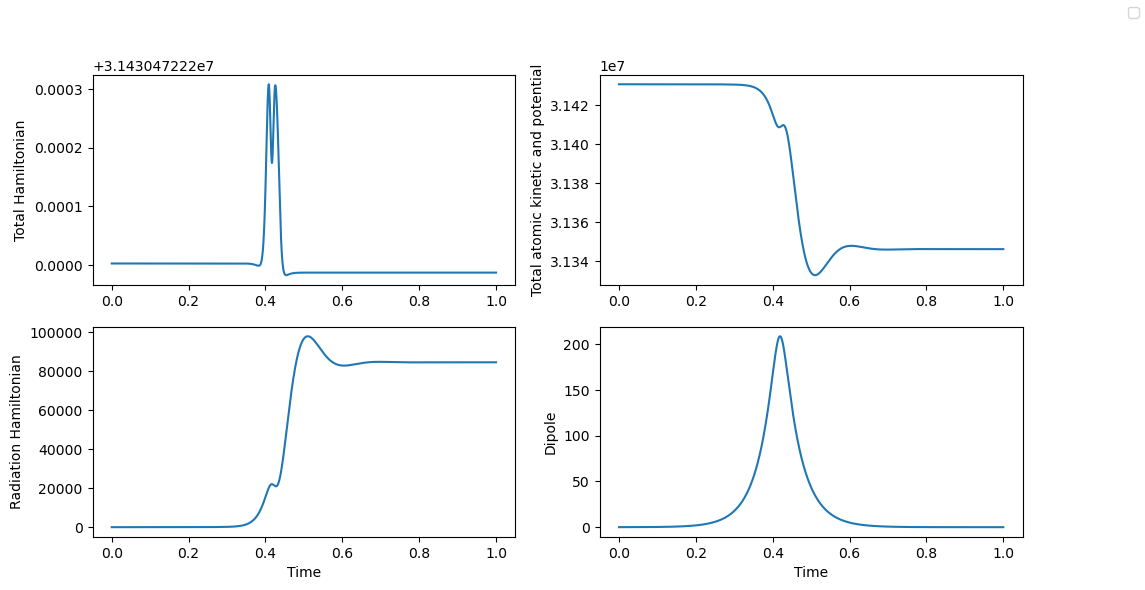

In [81]:
with open("result_plot//trajectory_temp.pkl","rb") as handle:
    trajectory_ = pickle.load(handle)
    
print("initial r_Ar: ", trajectory_["initial r_Ar"])
print("initial r_Xe: ", trajectory_["initial r_Xe"])
print("initial v_Ar: ", trajectory_["initial v_Ar"])
print("initial v_Xe: ", trajectory_["initial v_Xe"])
print("Cavity mode: ", trajectory_["k vector"])

fig,ax = plt.subplots(2,2,figsize = (12,6))

H_rad_list_ = np.array(trajectory_["H_rad"])
dipole_list = np.array(trajectory_["dipole"])
steps = np.array(trajectory_["steps"])
steps_ = np.array(steps)*h

ax[0][0].plot(steps_,trajectory_["total_H"])
ax[0][0].set_ylabel("Total Hamiltonian")

ax[0][1].plot(steps_,trajectory_["H_mat"])
ax[0][1].set_ylabel("Total atomic kinetic and potential")

linestyle = [
    "solid","dashed",(0, (1, 1)), 
    "dashdot", (5, (10, 3)), "solid", 
    (0, (5, 1)), (0, (3, 10, 1, 10))
   
]
"""
for i in range(H_rad_list_.shape[1]):
    ax[1][0].plot(steps_,H_rad_list_[:,i], label = str(i), linestyle = linestyle[i])
    
"""
ax[1][0].plot(steps_,np.sum(H_rad_list_, axis = 1))
ax[1][0].set_ylabel("Radiation Hamiltonian")
ax[1][0].set_xlabel("Time")

fig.legend()

ax[1][1].plot(steps_,dipole_list)
ax[1][1].set_ylabel("Dipole")
ax[1][1].set_xlabel("Time")

fig.savefig("Energy_n_dipole.jpeg",dpi=300,bbox_inches="tight")

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


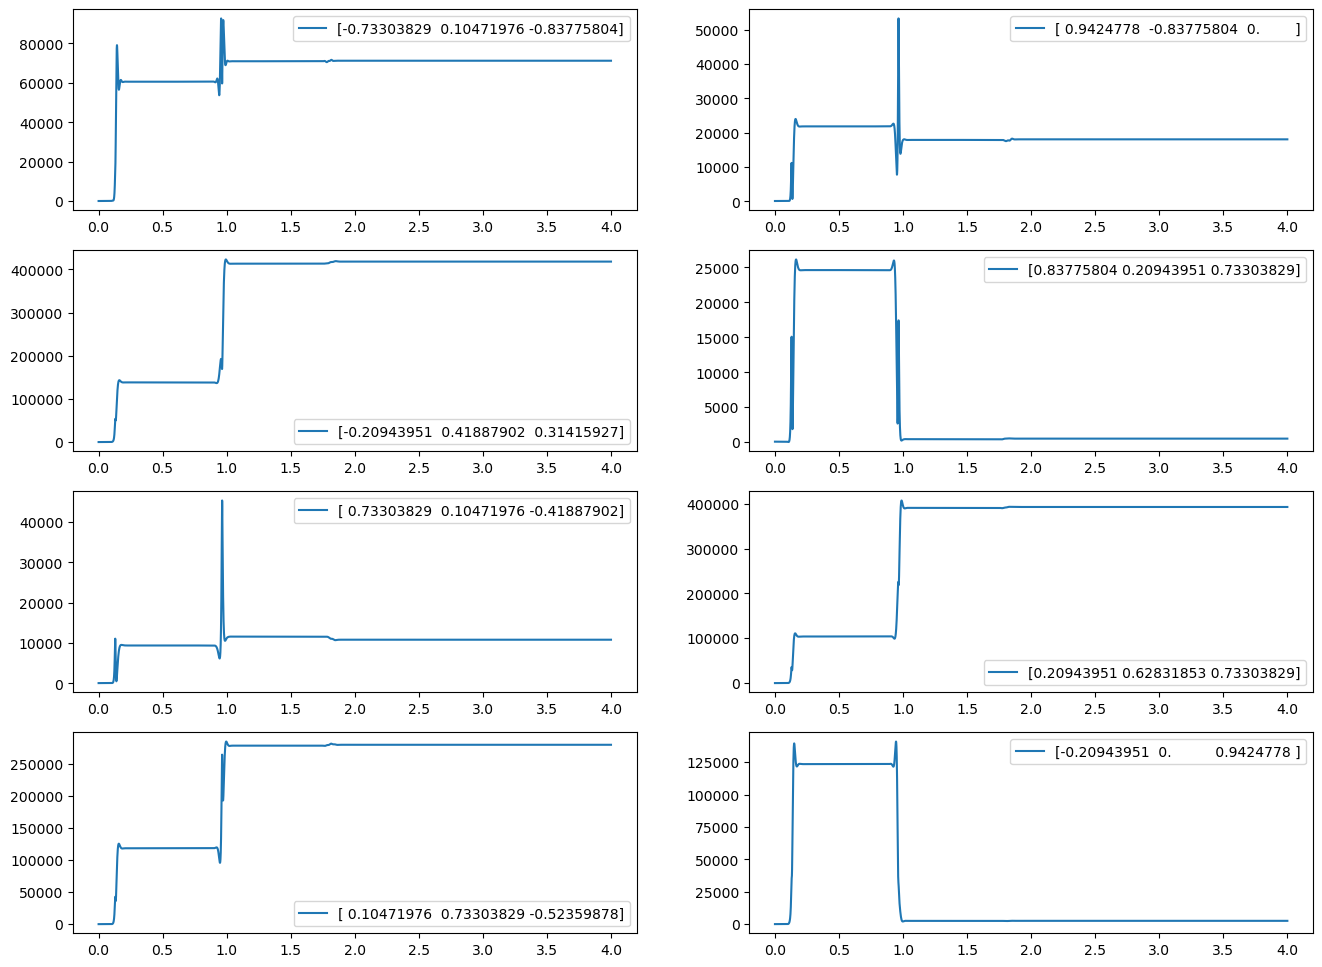

In [161]:
fig,ax = plt.subplots(4,2,figsize = (16,12))

for i in range(H_rad_list_.shape[1]):
    row = int(i / 2)
    col = i % 2
    ax[row][col].plot(
        steps_,H_rad_list_[:,i], 
        label = str(trajectory["k vector"][i])
    )
    ax[row][col].legend()

fig.savefig("radiation_H.jpeg",dpi=300,bbox_inches="tight")

In [81]:
np.array(trajectory_["r"]).shape

r_list = []
for i, r in enumerate(trajectory_["r"]):
    if i % 25 == 0:
        r_list.append(r)

In [83]:
trajectory["r"]

[array([[-4.99900000e+00,  4.35068936e-16, -3.62679438e-18],
        [ 4.35761952e-16, -4.99900000e+00, -3.65421610e-18],
        [ 4.99900000e+00, -5.68793191e-15, -8.95469646e-16],
        [-5.14767986e-15,  4.99900000e+00, -8.77208134e-16]]),
 array([[-4.97900000e+00,  1.76112784e-13, -5.82100277e-15],
        [ 1.77938287e-13, -4.97900000e+00, -5.89315655e-15],
        [ 4.97900000e+00, -2.54157106e-12, -4.01016968e-13],
        [-2.29971302e-12,  4.97900000e+00, -3.92847458e-13]]),
 array([[-4.95900000e+00,  6.08577953e-13, -3.90064530e-14],
        [ 6.21596609e-13, -4.95900000e+00, -3.95204311e-14],
        [ 4.95900000e+00, -9.80617946e-12, -1.55083803e-12],
        [-8.87117304e-12,  4.95900000e+00, -1.51927788e-12]]),
 array([[-4.93900000e+00,  1.20238750e-12, -1.25186242e-13],
        [ 1.24521386e-12, -4.93900000e+00, -1.26875057e-13],
        [ 4.93900000e+00, -2.19483404e-11, -3.47949918e-12],
        [-1.98512658e-11,  4.93900000e+00, -3.40876620e-12]]),
 array([[-4.9190

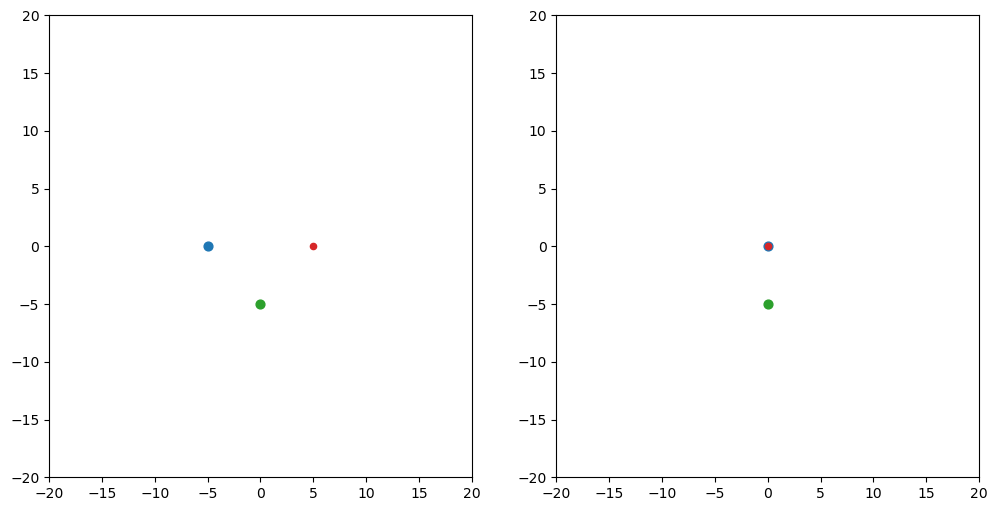

In [85]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

%matplotlib inline

assert len(trajectory["r"]) <= 3000

fig, ax = plt.subplots(1,2,figsize = (12,6))

scats = []

R = np.array(trajectory["r"][0])

for i in range(2):
    scats.append( ax[0].scatter(R[i, 0], R[i, 1], s = 40) )
    scats.append( ax[1].scatter(R[i, 2], R[i, 1], s = 40) )
    
    scats.append( ax[0].scatter(R[i+1, 0], R[i+1, 1], s = 20) )
    scats.append( ax[1].scatter(R[i+1, 2], R[i+1, 1], s = 20) )

ax[0].set_xlim(-L/2,L/2)
ax[0].set_ylim(-L/2,L/2)
ax[1].set_xlim(-L/2,L/2)
ax[1].set_ylim(-L/2,L/2)

def animate(j):
    R = np.array(trajectory["r"][j])

    for i in range(2):
        scats[0 + i*4].set_offsets(
            np.vstack([R[i, 0], R[i, 1]]).T
        )
        scats[1 + i*4].set_offsets(
            np.vstack([R[i, 2], R[i, 1]]).T
        )
    
        scats[2 + i*4].set_offsets(
            np.vstack([R[i+1, 0], R[i+1, 1]]).T
        )
        scats[3 + i*4].set_offsets(
            np.vstack([R[i+1, 2], R[i+1, 1]]).T
        )
    
ani = animation.FuncAnimation(fig, func=animate, frames= len(trajectory["r"]), interval = 0.1)

ani.save('result_plot/colliding_in_EM.html', writer=animation.HTMLWriter(fps= 1))

#ani.save(filename="result_plot/colliding_in_EM.gif", writer="pillow")

In [104]:
lennardj

R = np.arange(2,10,0.1)
potential = []
dipole = []
for i in R:
    potential.append(lennardj.get_potential(
        np.vstack([
            np.array([0,0,0]), np.array([i,0,0])
                    ])
    ))
    dipole.append(
        np.sum(dipole_func(np.array([0,0,0]), np.array([i,0,0]))**2)
    )

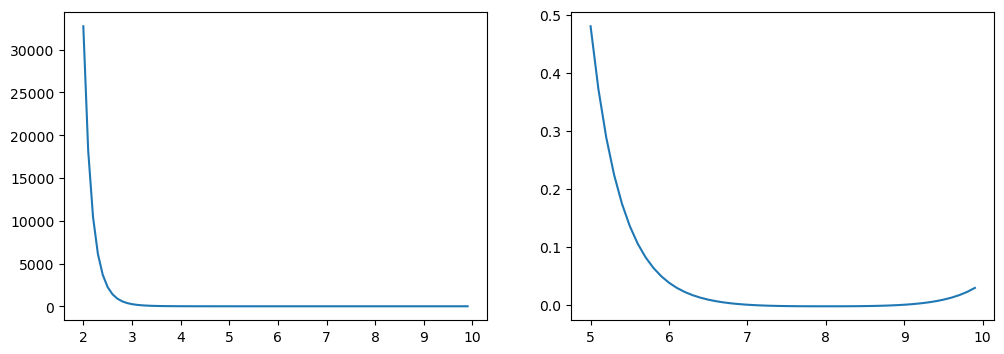

In [101]:
fig, ax = plt.subplots(1,2,figsize= (12,4))

ax[0].plot(R, potential)
ax[1].plot(R[30:], potential[30:])

fig.savefig("result_plot/potential.jpeg",dpi=600,bbox_inches="tight")

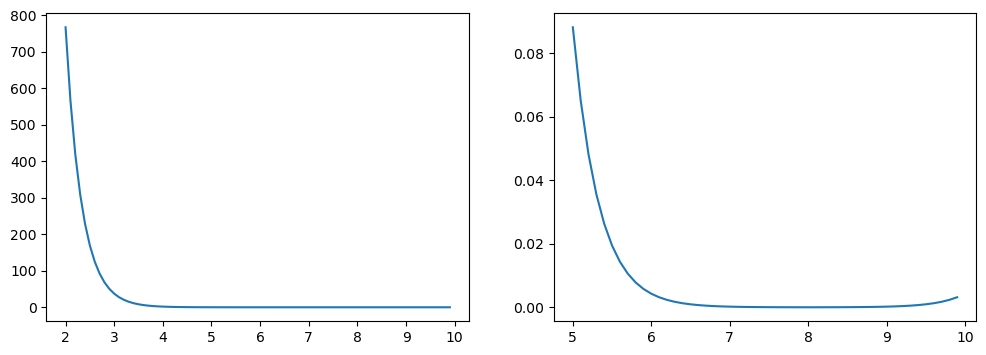

In [106]:
fig, ax = plt.subplots(1,2,figsize= (12,4))

ax[0].plot(R, dipole)
ax[1].plot(R[30:], dipole[30:])

fig.savefig("result_plot/dipole.jpeg",dpi=600,bbox_inches="tight")